<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению
<center>Автор материала: Варахобова Анна Андреевна, @h.varakhobava.

# <center>Обзор библиотеки статистического моделирования Statsmodels

В этом тьюториале будет рассмотрена библиотека statsmodels и некоторые популярные ее применения.

<a href="https://www.statsmodels.org">statsmodels</a> - это библиотека для статистического моделирования, содержащая всевозможные статистические модели, множество статистических тестов, средств для информативных графиков и др. Распространяется под лицензией New BSD (modified BSD).

Этот пакет покажется знакомым тем, кто работал со статистическим моделированием на R, т.к. позволяет пользоватся строковыми формулами для описания линейной модели, и содержит похожие методы и классы, а также позволяет пользоваться наборами данных из R.


### Линейная регрессия

Посмотрим, как решить задачу линейной регрессии с помощью statsmodels. В пакете statsmodels.api.datasets представлено некоторое количество датасетов, включая датасеты, доступные в R. Воспользуемся одним из них. 

Во встроенных данных не из R присутствуют свойства endog и exog - целевой и все остальные признаки соответственно, а сам массив лежит в свойстве data. В даных из R endog и exog свойств нет, а в data лежит pandas DataFrame.

In [4]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression, LinearRegression


In [30]:
data = sm.datasets.get_rdataset("Guerry", "HistData").data

In [31]:
data[:10]

,dept,Region,Department,Crime_pers,Crime_prop,Literacy,Donations,Infants,Suicides,MainCity,...,Crime_parents,Infanticide,Donation_clergy,Lottery,Desertion,Instruction,Prostitutes,Distance,Area,Pop1831
0,1,E,Ain,28870,15890,37,5098,33120,35039,2:Med,...,71,60,69,41,55,46,13,218.372,5762,346.03
1,2,N,Aisne,26226,5521,51,8901,14572,12831,2:Med,...,4,82,36,38,82,24,327,65.945,7369,513.00
2,3,C,Allier,26747,7925,13,10973,17044,114121,2:Med,...,46,42,76,66,16,85,34,161.927,7340,298.26
3,4,E,Basses-Alpes,12935,7289,46,2733,23018,14238,1:Sm,...,70,12,37,80,32,29,2,351.399,6925,155.90
4,5,E,Hautes-Alpes,17488,8174,69,6962,23076,16171,1:Sm,...,22,23,64,79,35,7,1,320.280,5549,129.10
5,7,S,Ardeche,9474,10263,27,3188,42117,52547,1:Sm,...,76,47,67,70,19,62,1,279.413,5529,340.73
6,8,N,Ardennes,35203,8847,67,6400,16106,26198,2:Med,...,53,85,49,31,62,9,83,105.694,5229,289.62
7,9,S,Ariege,6173,9597,18,3542,22916,123625,1:Sm,...,74,28,63,75,22,77,3,385.313,4890,253.12
8,10,E,Aube,19602,4086,59,3608,18642,10989,2:Med,...,77,54,9,28,86,15,207,83.244,6004,246.36
9,11,S,Aude,15647,10431,34,2582,20225,66498,2:Med,...,80,35,27,50,63,48,1,370.949,6139,270.13


In [32]:
data['Lottery'].head()

0    41
1    38
2    66
3    80
4    79
Name: Lottery, dtype: int64

Для обычной линейной регрессии используем OLS - ordinary least squares модель.

Сначала подготовим данные: удалим пропуски и закодируем категориальный признак Region, а затем обучим модель и выведем саммари.

In [60]:
df = data[['Lottery', 'Literacy', 'Wealth', 'Region']].dropna()

df_dumm = pd.get_dummies(df, columns=['Region'], drop_first=True)

# обучим, добавив к предикторам смещение
ols = sm.OLS(df_dumm['Lottery'], sm.add_constant(df_dumm.drop(['Lottery'], axis=1)))
res = ols.fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Lottery   R-squared:                       0.338
Model:                            OLS   Adj. R-squared:                  0.287
Method:                 Least Squares   F-statistic:                     6.636
Date:                Tue, 24 Apr 2018   Prob (F-statistic):           1.07e-05
Time:                        21:04:52   Log-Likelihood:                -375.30
No. Observations:                  85   AIC:                             764.6
Df Residuals:                      78   BIC:                             781.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         38.6517      9.456      4.087      0.000      19.826      57.478
Literacy      -0.1858      0.210     -0.886      0.378      -0.603       0.232
Wealth         0.4515      0.103      4.390      0.000       0.247       0.656
Region_E     -15.4278      9.727     -1.586      0.117     -34.793       3.938
Region_N     -10.0170      9.260     -1.082      0.283     -28.453       8.419
Region_S      -4.5483      7.279     -0.625      0.534     -19.039       9.943
Region_W     -10.0913      7.196     -1.402      0.165     -24.418       4.235
==============================================================================
Omnibus:                        3.049   Durbin-Watson:                   1.785
Prob(Omnibus):                  0.218   Jarque-Bera (JB):                2.694
Skew:                          -0.340   Prob(JB):                        0.260
Kurtosis:                       2.454   Cond. No.                         371.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

В саммари можно сразу без лишних телодвижений посмотреть статистические характеристики модели: коэффициенты модели, значимы ли они, их доверительные интервалы. Также выводится множество других параметров: метрики качества, значения статистических тестов.

Видим, что модель имеет R2 метрику, равную 0.3, так себе модель :) Высокие p-value коэффициентов говорят о том же.

#### Формулы
Проделаем то же самое, но с использованием формул, а также посмотрим, какие "чудеса" можно вытворять с их помощью.

Говорим модели, что хотим предсказать Lottery как линейную комбинацию остальных перечисленных параметров
добавляем вконце -1, чтобы убрать смещение, т.е. чтобы y = a1x1 + .. + anxn


In [61]:
res_f = smf.ols(formula='Lottery ~ Literacy + Wealth + Region', data=df).fit()
res_f.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Lottery   R-squared:                       0.338
Model:                            OLS   Adj. R-squared:                  0.287
Method:                 Least Squares   F-statistic:                     6.636
Date:                Tue, 24 Apr 2018   Prob (F-statistic):           1.07e-05
Time:                        21:05:22   Log-Likelihood:                -375.30
No. Observations:                  85   AIC:                             764.6
Df Residuals:                      78   BIC:                             781.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      38.6517      9.456      4.087      0.000      19.826      57.478
Region[T.E]   -15.4278      9.727     -1.586      0.117     -34.793       3.938
Region[T.N]   -10.0170      9.260     -1.082      0.283     -28.453       8.419
Region[T.S]    -4.5483      7.279     -0.625      0.534     -19.039       9.943
Region[T.W]   -10.0913      7.196     -1.402      0.165     -24.418       4.235
Literacy       -0.1858      0.210     -0.886      0.378      -0.603       0.232
Wealth          0.4515      0.103      4.390      0.000       0.247       0.656
==============================================================================
Omnibus:                        3.049   Durbin-Watson:                   1.785
Prob(Omnibus):                  0.218   Jarque-Bera (JB):                2.694
Skew:                          -0.340   Prob(JB):                        0.260
Kurtosis:                       2.454   Cond. No.                         371.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Как видим, тот же результат получен более удобно, без ручных преобразований признаков. 


С помощью формул также можно катеригоризировать признаки, удалять сонстанту (смещение), конструировать произведение признаков, а также применять к ним функции. Для экономии пространства будем выводить только параметры модели.

In [62]:
# категоризация
res_f = smf.ols(formula='Lottery ~ Literacy + Wealth + C(Region)', data=df).fit()
res_f.params

Intercept         38.651655
C(Region)[T.E]   -15.427785
C(Region)[T.N]   -10.016961
C(Region)[T.S]    -4.548257
C(Region)[T.W]   -10.091276
Literacy          -0.185819
Wealth             0.451475
dtype: float64

In [63]:
# удаляем смещение
res_f = smf.ols(formula='Lottery ~ Literacy + Wealth + C(Region) - 1', data=df).fit()
res_f.params

C(Region)[C]    38.651655
C(Region)[E]    23.223870
C(Region)[N]    28.634694
C(Region)[S]    34.103399
C(Region)[W]    28.560379
Literacy        -0.185819
Wealth           0.451475
dtype: float64

In [64]:
# заменим два признака на их произведение
res_f = smf.ols(formula='Lottery ~ Literacy:Wealth + C(Region) - 1', data=df).fit()
res_f.params

C(Region)[C]       47.812953
C(Region)[E]       15.970539
C(Region)[N]       20.187009
C(Region)[S]       38.956475
C(Region)[W]       36.721927
Literacy:Wealth     0.006999
dtype: float64

In [66]:
# добавим произведение двух признаков, но оставим исходные
res_f = smf.ols(formula='Lottery ~ Literacy*Wealth + C(Region) - 1', data=df).fit()
res_f.params

C(Region)[C]       39.099330
C(Region)[E]       23.654199
C(Region)[N]       29.126530
C(Region)[S]       34.523917
C(Region)[W]       28.987171
Literacy           -0.196046
Wealth              0.443209
Literacy:Wealth     0.000200
dtype: float64

In [67]:
# применим функцию к признаку
res_f = smf.ols(formula='Lottery ~ np.log(Literacy) + Wealth', data=df).fit()
res_f.params

Intercept           74.611024
np.log(Literacy)   -13.778252
Wealth               0.400571
dtype: float64

Но самая полезная киллер-фича формул - возможность использовать их в моделях, не поддреживающих такую запись. Для этого нам понадобится библиотека patsy. 

In [68]:
import patsy

f = 'Lottery ~ Literacy * Wealth + C(Region) - 1'

y, X = patsy.dmatrices(f, df, return_type='dataframe')

In [69]:
X.head()

,C(Region)[C],C(Region)[E],C(Region)[N],C(Region)[S],C(Region)[W],Literacy,Wealth,Literacy:Wealth
0,0.0,1.0,0.0,0.0,0.0,37.0,73.0,2701.0
1,0.0,0.0,1.0,0.0,0.0,51.0,22.0,1122.0
2,1.0,0.0,0.0,0.0,0.0,13.0,61.0,793.0
3,0.0,1.0,0.0,0.0,0.0,46.0,76.0,3496.0
4,0.0,1.0,0.0,0.0,0.0,69.0,83.0,5727.0


### Робастная регрессия

Иногда в данных присутсвуют выбросы, которые влияют на качество модели. В таких случаях можно использовать линейную модель, устойчивую к ним, - RLM.

In [123]:
nsample = 50

new_df = pd.DataFrame()
new_df['x1'] = np.linspace(0, 20, nsample)
new_df['x2'] = (new_df['x1'] - 5)**2

sig = 0.3   # маленькая вариация, больше разницы между моделями OLS и RLM
beta = [0.5, -0.0]
kx = np.dot(new_df.values, beta)
y= kx + sig*1. * np.random.normal(size=nsample)
y_true = kx.copy() # значения без выбросов
y[[38,40,42,45,49]] -= 5  # выбросы

In [124]:
new_df['y'] = y

In [125]:
ols_res = smf.ols('y ~ x1 + x2', data=new_df).fit()
ols_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.778
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                     82.46
Date:                Tue, 24 Apr 2018   Prob (F-statistic):           4.26e-16
Time:                        22:13:14   Log-Likelihood:                -84.193
No. Observations:                  50   AIC:                             174.4
Df Residuals:                      47   BIC:                             180.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0536      0.449     -0.119      0.905      -0.956       0.849
x1             0.5297      0.069      7.645      0.000       0.390       0.669
x2            -0.0120      0.006     -1.958      0.056      -0.024       0.000
==============================================================================
Omnibus:                       21.157   Durbin-Watson:                   2.588
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.404
Skew:                          -1.438   Prob(JB):                     2.50e-07
Kurtosis:                       5.515   Cond. No.                         214.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Обучим RLM модель

In [126]:
res_rlm = smf.rlm('y ~ x1 + x2', data=new_df).fit()
res_rlm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                      y   No. Observations:                   50
Model:                            RLM   Df Residuals:                       47
Method:                          IRLS   Df Model:                            2
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Tue, 24 Apr 2018                                         
Time:                        22:13:18                                         
No. Iterations:                    44                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1361      0.123     -1.110      0.267      -0.376       0.104
x1             0.5232      0.019     27.633      0.000       0.486       0.560
x2            -0.0024      0.002     -1.433      0.152      -0.006       0.001
==============================================================================

If the model instance has been used for another fit with different fit
parameters, then the fit options might not be the correct ones anymore .
"""

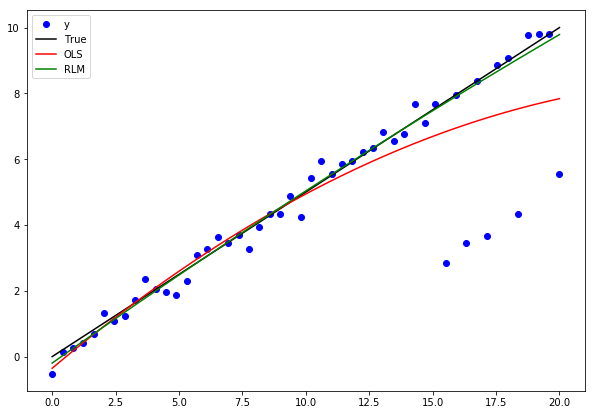

In [127]:
new_df['fitted_ols'] = ols_res.fittedvalues
new_df['fitted_rlm'] = res_rlm.fittedvalues

plt.figure(figsize=(10, 7))
plt.plot(new_df.x1.values, y, 'o', c='b', label='y')
plt.plot(new_df.x1.values, y_true, c='black', label='True')
plt.plot(new_df.x1, new_df.fitted_ols, c='r', label='OLS')
plt.plot(new_df.x1, new_df.fitted_rlm, c='g', label='RLM')
plt.legend(loc="best")

Как видим, RLM справляется с выбросами гораздо лучше OLS. В качестве робастной нормы можно передавать LeastSquares, HuberT, RamsayE, AndrewWave, TrimmedMean, Hampel, and TukeyBiweight из пакета sm.robust.norms (подробнее <a href="https://www.statsmodels.org/stable/rlm.html">тут</a> )

### GLM и компания

Линейная регрессия накладывает на данные некоторые ограничения, в частности, нормальность распределения ошибок и целевой переменной, а также линейность предсказаний. Но что если это не так? Можно долго мучаться с преобразованием данных, а можно посмотреть в сторону GLM - <a href='https://en.wikipedia.org/wiki/Generalized_linear_model'>generalized linear model</a>. GLM часто применяется в страховании для моделирования частоты заявлений об ущербе и среднего размера выплат, чтобы рассчитать размер взноса за полис, а также в других случаях, когда целевая переменная распределена не по нормальному закону.
<br>
<br>
Рассмотрим применение модели.

In [131]:
ds = sm.datasets.star98.load()
print(sm.datasets.star98.NOTE)

::

    Number of Observations - 303 (counties in California).

    Number of Variables - 13 and 8 interaction terms.

    Definition of variables names::

        NABOVE   - Total number of students above the national median for the
                   math section.
        NBELOW   - Total number of students below the national median for the
                   math section.
        LOWINC   - Percentage of low income students
        PERASIAN - Percentage of Asian student
        PERBLACK - Percentage of black students
        PERHISP  - Percentage of Hispanic students
        PERMINTE - Percentage of minority teachers
        AVYRSEXP - Sum of teachers' years in educational service divided by the
                number of teachers.
        AVSALK   - Total salary budget including benefits divided by the number
                   of full-time teachers (in thousands)
        PERSPENK - Per-pupil spending (in thousands)
        PTRATIO  - Pupil-teacher ratio.
        PCTAF    - Percenta

In [137]:
ds.data[:1]

rec.array([(452., 355., 34.3973, 23.2993, 14.23528, 11.41112, 15.91837, 14.70646, 59.15732, 4.445207, 21.71025, 57.03276, 0., 22.22222, 234.102872, 941.68811, 869.9948, 96.50656, 253.52242, 1238.1955, 13848.8985, 5504.0352)],
          dtype=[('NABOVE', '<f8'), ('NBELOW', '<f8'), ('LOWINC', '<f8'), ('PERASIAN', '<f8'), ('PERBLACK', '<f8'), ('PERHISP', '<f8'), ('PERMINTE', '<f8'), ('AVYRSEXP', '<f8'), ('AVSALK', '<f8'), ('PERSPENK', '<f8'), ('PTRATIO', '<f8'), ('PCTAF', '<f8'), ('PCTCHRT', '<f8'), ('PCTYRRND', '<f8'), ('PERMINTE_AVYRSEXP', '<f8'), ('PERMINTE_AVSAL', '<f8'), ('AVYRSEXP_AVSAL', '<f8'), ('PERSPEN_PTRATIO', '<f8'), ('PERSPEN_PCTAF', '<f8'), ('PTRATIO_PCTAF', '<f8'), ('PERMINTE_AVYRSEXP_AVSAL', '<f8'), ('PERSPEN_PTRATIO_PCTAF', '<f8')])

In [138]:
ds.endog[:3], ds.exog[:3]

(array([[452., 355.],
        [144.,  40.],
        [337., 234.]]),
 array([[3.43973000e+01, 2.32993000e+01, 1.42352800e+01, 1.14111200e+01,
         1.59183700e+01, 1.47064600e+01, 5.91573200e+01, 4.44520700e+00,
         2.17102500e+01, 5.70327600e+01, 0.00000000e+00, 2.22222200e+01,
         2.34102872e+02, 9.41688110e+02, 8.69994800e+02, 9.65065600e+01,
         2.53522420e+02, 1.23819550e+03, 1.38488985e+04, 5.50403520e+03],
        [1.73650700e+01, 2.93283800e+01, 8.23489700e+00, 9.31488400e+00,
         1.36363600e+01, 1.60832400e+01, 5.95039700e+01, 5.26759800e+00,
         2.04427800e+01, 6.46226400e+01, 0.00000000e+00, 0.00000000e+00,
         2.19316851e+02, 8.11417560e+02, 9.57016600e+02, 1.07684350e+02,
         3.40406090e+02, 1.32106640e+03, 1.30502233e+04, 6.95884680e+03],
        [3.26432400e+01, 9.22638600e+00, 4.24063100e+01, 1.35437200e+01,
         2.88343600e+01, 1.45955900e+01, 6.05699200e+01, 5.48292200e+00,
         1.89541900e+01, 5.39419100e+01, 0.00000000e+0

Обучим GLM, указав распределениe sm.families.Binomial

In [140]:
res = sm.GLM(ds.endog, ds.exog, family=sm.families.Binomial()).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           ['y1', 'y2']   No. Observations:                  303
Model:                            GLM   Df Residuals:                      283
Model Family:                Binomial   Df Model:                           19
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -3000.5
Date:                Tue, 24 Apr 2018   Deviance:                       4082.4
Time:                        22:43:43   Pearson chi2:                     9.50
No. Iterations:                     5                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0169      0.000    -39.491      0.000      -0.018      -0.016
x2             0.0101      0.001     16.832      0.000       0.009       0.011
x3            -0.0186      0.001    -25.132      0.000      -0.020      -0.017
x4            -0.0142      0.000    -32.755      0.000      -0.015      -0.013
x5             0.2778      0.027     10.154      0.000       0.224       0.331
x6             0.2937      0.050      5.872      0.000       0.196       0.392
x7             0.0930      0.012      7.577      0.000       0.069       0.117
x8            -1.4432      0.171     -8.461      0.000      -1.777      -1.109
x9            -0.2347      0.032     -7.283      0.000      -0.298      -0.172
x10           -0.1179      0.019     -6.351      0.000      -0.154      -0.081
x11            0.0047      0.001      3.748      0.000       0.002       0.007
x12           -0.0036      0.000    -16.239      0.000      -0.004      -0.003
x13           -0.0157      0.002     -9.142      0.000      -0.019      -0.012
x14           -0.0044      0.000    -10.137      0.000      -0.005      -0.004
x15           -0.0048      0.001     -5.646      0.000      -0.006      -0.003
x16            0.0686      0.008      8.587      0.000       0.053       0.084
x17            0.0372      0.004      9.099      0.000       0.029       0.045
x18            0.0057      0.001      6.760      0.000       0.004       0.007
x19            0.0002   2.68e-05      9.237      0.000       0.000       0.000
x20           -0.0017      0.000     -8.680      0.000      -0.002      -0.001
==============================================================================
"""

Посмотрим на остатки модели, для этого построим гистограмму распределения дисперсии остатков и построим Q-Q plot с помощью statsmodels.graphics.

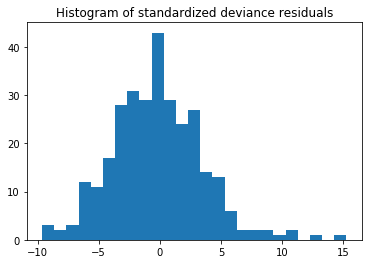

In [145]:
from scipy import stats

plt.hist(res.resid_deviance.copy(), bins=25)
plt.title('Histogram of standardized deviance residuals');

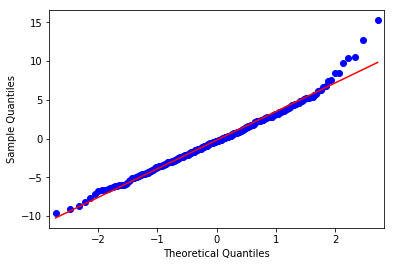

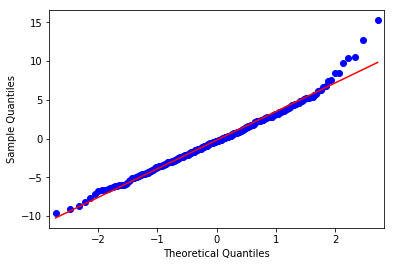

In [147]:
from statsmodels import graphics

graphics.gofplots.qqplot(resid, line='r')

Видим, что остатки распределены нормально. 

В statsmodels также реализованы расширения GLM: **GEE**, **MixedLM** - для кластеризованных данных, не скореллированных между кластерами, но внутри кластеров, и с наличием случайных корреляций неизвестной природы. Подробнее <a href="https://www.statsmodels.org/stable/gee.html">тут</a> и <a href = "https://www.statsmodels.org/stable/mixed_linear.html">тут</a>

### Логистическая регрессия

Посмотрим, как применить statsmodels к задаче классификации:

In [190]:
spector_data = sm.datasets.spector.load()
print(sm.datasets.spector.NOTE)

::

    Number of Observations - 32

    Number of Variables - 4

    Variable name definitions::

        Grade - binary variable indicating whether or not a student's grade
                improved.  1 indicates an improvement.
        TUCE  - Test score on economics test
        PSI   - participation in program
        GPA   - Student's grade point average



In [196]:
spector_data.data

rec.array([(2.66, 20., 0., 0.), (2.89, 22., 0., 0.), (3.28, 24., 0., 0.),
           (2.92, 12., 0., 0.), (4.  , 21., 0., 1.), (2.86, 17., 0., 0.),
           (2.76, 17., 0., 0.), (2.87, 21., 0., 0.), (3.03, 25., 0., 0.),
           (3.92, 29., 0., 1.), (2.63, 20., 0., 0.), (3.32, 23., 0., 0.),
           (3.57, 23., 0., 0.), (3.26, 25., 0., 1.), (3.53, 26., 0., 0.),
           (2.74, 19., 0., 0.), (2.75, 25., 0., 0.), (2.83, 19., 0., 0.),
           (3.12, 23., 1., 0.), (3.16, 25., 1., 1.), (2.06, 22., 1., 0.),
           (3.62, 28., 1., 1.), (2.89, 14., 1., 0.), (3.51, 26., 1., 0.),
           (3.54, 24., 1., 1.), (2.83, 27., 1., 1.), (3.39, 17., 1., 1.),
           (2.67, 24., 1., 0.), (3.65, 21., 1., 1.), (4.  , 23., 1., 1.),
           (3.1 , 21., 1., 0.), (2.39, 19., 1., 1.)],
          dtype=[('GPA', '<f8'), ('TUCE', '<f8'), ('PSI', '<f8'), ('GRADE', '<f8')])

In [200]:

### если при запуске выдается ошибка "module 'scipy.stats' has no attribute 'chisqprob'", 
### раскомментируйте строки ниже
# from scipy import stats
# stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

res_logit = smf.logit('GRADE ~ TUCE + PSI + GPA', data=spector_data.data).fit()
res_logit.summary()

Optimization terminated successfully.
         Current function value: 0.402801
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  GRADE   No. Observations:                   32
Model:                          Logit   Df Residuals:                       28
Method:                           MLE   Df Model:                            3
Date:                Tue, 24 Apr 2018   Pseudo R-squ.:                  0.3740
Time:                        23:27:32   Log-Likelihood:                -12.890
converged:                       True   LL-Null:                       -20.592
                                        LLR p-value:                  0.001502
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -13.0213      4.931     -2.641      0.008     -22.687      -3.356
TUCE           0.0952      0.142      0.672      0.501      -0.182       0.373
PSI            2.3787      1.065      2.234      0.025       0.292       4.465
GPA            2.8261      1.263      2.238      0.025       0.351       5.301
==============================================================================
"""

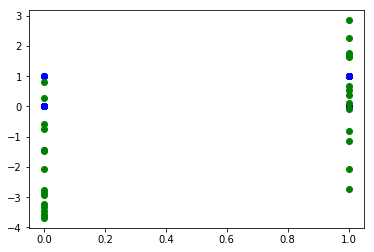

In [201]:
plt.plot(spector_data.data['PSI'], spector_data.data['GRADE'], 'o', c='b')
plt.plot(spector_data.data['PSI'], res_logit.fittedvalues, 'o', c='g')

### EDA
В модуле statsmodels.grphics есть много других возможностей для визуального анализа данных, посмотрим на некоторые из них.

In [158]:
ds.exog.shape

(303, 20)

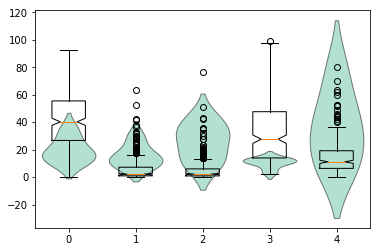

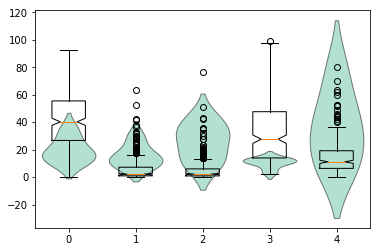

In [162]:
from statsmodels.graphics import boxplots, correlation, regressionplots

boxplots.violinplot(ds.exog[:, :5], positions=[0, 1, 2, 3, 4])

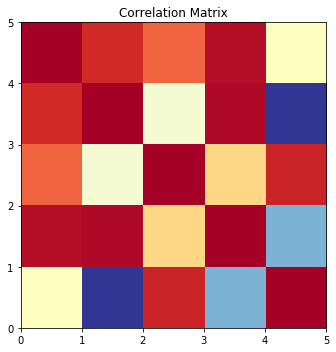

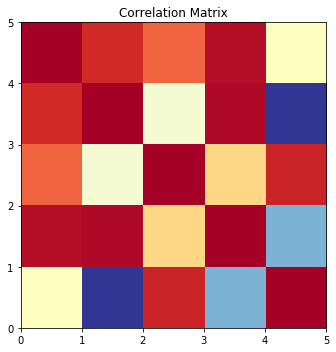

In [180]:
cm = np.corrcoef(ds.exog[:5])

fig, ax = plt.subplots(figsize=(5, 5))
correlation.plot_corr(cm, ax=ax)

Мощный тул для отображения результатов регрессии:

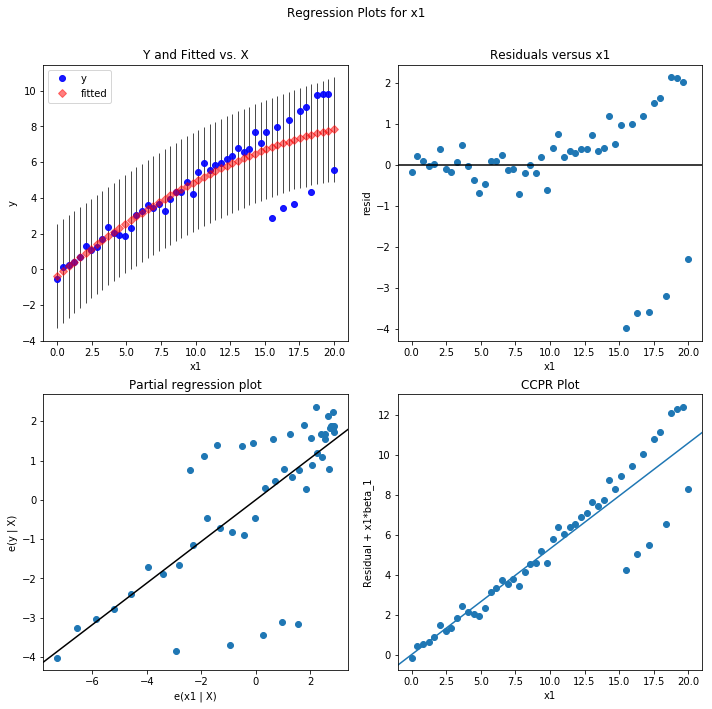

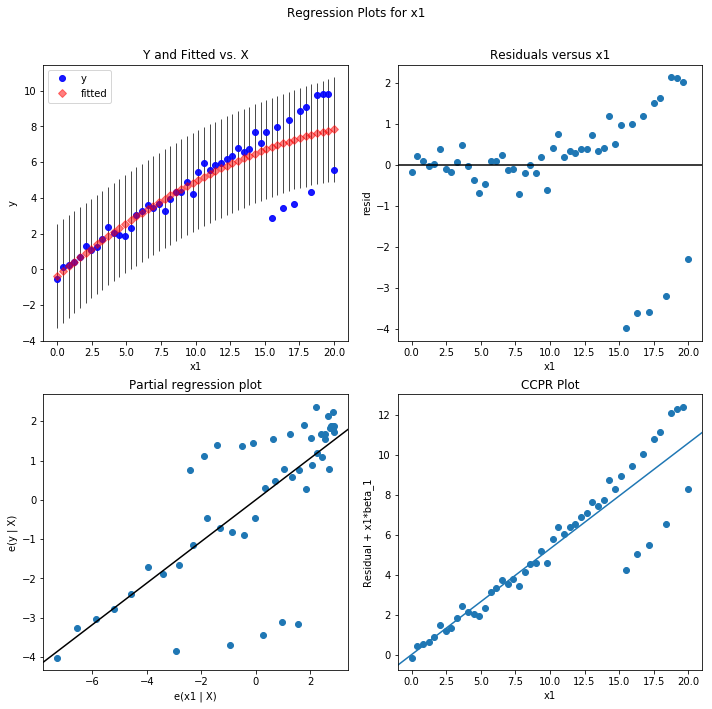

In [187]:
f = plt.figure(figsize=(10, 10))
regressionplots.plot_regress_exog(ols_res, 1, fig=f)

### Полезные функции

В библиотеке много полезных функций, сосредоточены они в модуле statsmodels.tools.tools.

Категоризация:

In [208]:
from statsmodels.tools import tools

tools.categorical(df.Region.values)[:5]

array([['E', 0.0, 1.0, 0.0, 0.0, 0.0],
       ['N', 0.0, 0.0, 1.0, 0.0, 0.0],
       ['C', 1.0, 0.0, 0.0, 0.0, 0.0],
       ['E', 0.0, 1.0, 0.0, 0.0, 0.0],
       ['E', 0.0, 1.0, 0.0, 0.0, 0.0]], dtype=object)

Добавление смещения к признакам, полезно, если исплользуем модель без формул:

In [209]:
tools.add_constant(df).head()

,const,Lottery,Literacy,Wealth,Region
0,1.0,41,37,73,E
1,1.0,38,51,22,N
2,1.0,66,13,61,C
3,1.0,80,46,76,E
4,1.0,79,69,83,E


Метрики точности предсказания:

In [215]:
from statsmodels.tools import eval_measures

ols_rmse = eval_measures.rmse(y, ols_res.fittedvalues)
ols_mse = eval_measures.mse(y, ols_res.fittedvalues)
print('OLS metrics: {}, {}'.format(ols_rmse, ols_mse))

rlm_rmse = eval_measures.rmse(y_true, res_rlm.fittedvalues)
rlm_mse = eval_measures.mse(y_true, res_rlm.fittedvalues)
print('RLM metrics: {}, {}'.format(rlm_rmse, rlm_mse))


OLS metrics: 1.3033303873084205, 1.6986700984815177
RLM metrics: 0.08842459174962938, 0.007818908426088626


## Заключение

В этом тьюториале мы рассмотрели самые расспространенные приемы моделирования и другие полезные инструменты statsmodels. В библиотеке еще много всего: ANOVA, непараметрические методы, методы прогнозирования временных рядов, статистические тесты.

В рассмотренных случаях библиотека имеет ряд преимуществ перед slkearn:
* лаконичность
* развернутое саммари по модели из коробки
* формулы
* множество статистических интсрументов и проверок
* минималистичность в целом

Так что если вам не нужно что-то сложное типа градиентного бустинга, statsmodels отлично подойдет

Спасибо за внимание!